# Car Resale Marketplace Data Mining Project
#### Project Advisor: Prof. Arindam Ray
#### Team Name: Beta Busters
#### Team Members: 
1. Amolika Godse 
2. Anuraag Gujje 
3. Ganesh Talluri 
4. Sai Sudheer Vishnumolakala 
5. Suraj Shiva Kumar


### Problem Statement

We propose a data mining project to create a car resale marketplace that enables users to sell and buy resale cars. The key objectives of this project are as follows:

1. Predict the resale price of cars based on their features, helping sellers set competitive prices.

2. Recommend similar cars to potential buyers based on their preferences.


### A) Import Libraries

###### The code imports several essential Python libraries for data manipulation, visualization, and machine learning. 
> 1. Pandas is used for data handling, NumPy for numerical operations, Matplotlib for creating plots. 
> 2. Seaborn for statistical visualizations. The Pickle library is included for serializing Python objects.  
> 3. From scikit-learn (sklearn)imported: 
                  > train_test_split for data splitting.
                  > RandomizedSearchCV for hyperparameter tuning.
                  > ColumnTransformer, StandardScaler, OrdinalEncoder, and OneHotEncoder for data preprocessing.
                  > Pipeline for combining preprocessing and modeling steps
> 4. Regression models including LinearRegression, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor, and MLPRegressor. 
> 5. RFECV for feature selection.
> 6. Metrics like mean_squared_error, r2_score, and make_scorer for evaluating regression models.
----



In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

### B) Data Loading & Checks

In [252]:
df = pd.read_csv('cleansed_master_data.csv')

In [253]:
df.head()

,price,type,make,year,model,miles_driven,doors,engine,transmission,drive_type,...,parking_assist_system,stability_control,adaptive_cruise_control,alloy_wheels,cooled_seats,full_self-driving_capability,third_row_seating,tow_hitch_package,rear_seat_entertainment,avg_mpg
0,32589,sedan,subaru,2022.0,wrx,14172.0,4,4 cyl,manual,awd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.5
1,32589,sedan,audi,2022.0,a3,7729.0,4,4 cyl,automatic,awd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
2,48589,sedan,bmw,2023.0,5 series,25001.0,4,4 cyl,automatic,rwd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
3,24589,sedan,hyundai,2023.0,elantra,8677.0,4,4 cyl,automatic,fwd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0
4,23999,sedan,hyundai,2023.0,elantra,16506.0,4,4 cyl,automatic,fwd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0


In [254]:
df.shape

(2887, 42)

In [255]:
num_features = ['miles_driven', 'avg_mpg']
cat_features_label = ['type', 'make', 'model', 'transmission', 'drive_type', 'fuel', 'engine']
cat_features_ordinal = ['year', 'doors']

In [256]:
bin_features = ['apple_carplay', 'backup_camera_assist', 'bluetooth', 'heated_seats',
                'hill_assist_system', 'keyless_entry', 'keyless_ignition', 'multimedia_telematics', 'premium_sound_system',
                'satellite_radio', 'sunroof_moonroof', 'leather_seats', 'power_seats', 'traction_control',
                'driver_assistance_confidence_pkg', 'head-up_display', 'lane_departure_warning', 'navigation_system',
                'remote_start', 'blind_spot_monitor', 'lane_assist', 'parking_assist_system', 'stability_control', 
                'adaptive_cruise_control', 'alloy_wheels', 'cooled_seats', 'full_self-driving_capability',
                'third_row_seating', 'tow_hitch_package', 'rear_seat_entertainment']

In [257]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat_label', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features_label),
        ('cat_ordinal', OrdinalEncoder(), cat_features_ordinal),
        ('binary', 'passthrough', bin_features)])

### E) Train & Test Split

In [258]:
# Split the data into features (X) and target (y)
X = df.drop(columns=['price'])
y = df[['price']]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['type'])

In [259]:
pd.concat([X_train.type.value_counts(),X_test.type.value_counts(),X.type.value_counts()],axis=1)

,type,type,type
supuv,1162,291,1453
sedan,539,135,674
pickups,283,71,354
coupe,109,28,137
hatchback,86,21,107
convertible,46,11,57
minivan,44,11,55
wagon,40,10,50


### F) Model Fitting

#### Random Forest Regressor

#### Modeling Random Forest regressor before hyperparameter tuning 

In [260]:
rf_model = RandomForestRegressor(random_state=42)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])
# Fit the pipeline on the training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'head-up_display',
                                                   'lane_departure_warning',
                                                   'navigation_system',
                                                   'remote_start',
                                                   'blind_spot_monitor',
                                                   'lane_assist',
                                                   'parking_assist_system',
                                                   'stability_control',
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model', RandomForestRegressor(random_state=42))])

#### Hypertuning the Random Forest Regressor 

In [26]:


best_params = None
best_loss = float('inf')  # Initialize with a high value
trials = Trials()
# Define a custom callback function to display hyperparameters and loss
def custom_callback(params):
    global best_params,best_loss
    loss = objective(params)

    # Check if the current loss is an improvement
    if loss < best_loss:
        best_params = params
        best_loss = loss
        print("Improved Hyperparameters:", best_params)
        print("Improved Loss:", best_loss)
    else:
        print("Hyperparameters:", params)
        print("Loss:", loss)

    return {'loss': loss, 'status': 'ok'}

def objective(params):
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']

    rfr = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    neg_mse = -np.mean(cross_val_score(rfr, preprocessor.fit_transform(X_train), y_train, scoring='neg_mean_squared_error', cv=3))

    return neg_mse

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(200,400,50)),
    'max_depth': hp.choice('max_depth', np.arange(50,500,50))
}

# Perform the optimization
best = fmin(
    fn=custom_callback,  # Use the custom callback function
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:", best)

# Use the best hyperparameters







Improved Hyperparameters:                              
{'max_depth': 50, 'n_estimators': 200}                 
Improved Loss:                                         
22182562.66294195                                      
Improved Hyperparameters:                                                       
{'max_depth': 250, 'n_estimators': 350}                                         
Improved Loss:                                                                  
22053576.928227346                                                              
Hyperparameters:                                                                   
{'max_depth': 400, 'n_estimators': 350}                                            
Loss:                                                                              
22053576.928227346                                                                 
Hyperparameters:                                                                   
{'max_depth': 200, 'n_estimators

Hyperparameters:                                                                  
{'max_depth': 450, 'n_estimators': 300}                                           
Loss:                                                                             
22112696.79537865                                                                 
Hyperparameters:                                                                  
{'max_depth': 250, 'n_estimators': 250}                                           
Loss:                                                                             
22156830.621653136                                                                
Hyperparameters:                                                                  
{'max_depth': 350, 'n_estimators': 350}                                           
Loss:                                                                             
22053576.928227346                                                                
Hype

Loss:                                                                                
22053576.928227346                                                                   
Hyperparameters:                                                                     
{'max_depth': 400, 'n_estimators': 350}                                              
Loss:                                                                                
22053576.928227346                                                                   
Hyperparameters:                                                                     
{'max_depth': 400, 'n_estimators': 250}                                              
Loss:                                                                                
22156830.621653136                                                                   
Hyperparameters:                                                                     
{'max_depth': 200, 'n_estimators': 350}               

#### Modeling Random Forest regressor after hyperparameter tuning 

In [379]:
#best_n_estimators = np.arange(200,400,50)[best['n_estimators']]
#best_max_depth = np.arange(50,500,50)[best['max_depth']]

hrf_model = RandomForestRegressor(
    n_estimators=np.arange(200,400,50)[3],
    max_depth=np.arange(50,500,50)[3],
    random_state=42
)

# Create the full pipeline
hrf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', hrf_model)
])

In [380]:
# Fit the pipeline on the training data
hrf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'navigation_system',
                                                   'remote_start',
                                                   'blind_spot_monitor',
                                                   'lane_assist',
                                                   'parking_assist_system',
                                                   'stability_control',
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model',
                 RandomForestRegressor(max_depth=200, n_estimators=350,
                                       random_state=42))])

#### MLP Regressor

#### Modeling MLP regressor before hyperparameter tuning 

In [264]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', mlp_model)
])

In [265]:
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'navigation_system',
                                                   'remote_start',
                                                   'blind_spot_monitor',
                                                   'lane_assist',
                                                   'parking_assist_system',
                                                   'stability_control',
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000,
                              random_state=42))])

#### Modeling Random Forest regressor after hyperparameter tuning 

In [29]:

mlp_model = MLPRegressor()
# Define the objective function
def objective(params):
    # Convert hyperparameters to the appropriate types
    hidden_layer_sizes = (int(params['hidden_layer1']), int(params['hidden_layer2']))
    # max_iter = int(params['max_iter'])
    random_state = int(params['random_state'])

    # Create an MLPRegressor model with the given hyperparameters
    mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=100, random_state=random_state)

    # Create a pipeline with the preprocessor and the MLP model
    mlp_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mlp_model)
    ])

    # Fit the model and evaluate it using cross-validation
    scores = cross_val_score(mlp_model, preprocessor.fit_transform(X_train), y_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean squared error
    mse = -np.mean(scores)

    return {'loss': mse, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'hidden_layer1': hp.quniform('hidden_layer1', 50, 200, 1),
    'hidden_layer2': hp.quniform('hidden_layer2', 25, 100, 1),
    'random_state' : hp.quniform('random_state', 0, 100, 1)
}

# Create a Trials object to keep track of the optimization process
trials = Trials()

# Use the Tree Parzen Estimator (TPE) algorithm to search for the best hyperparameters
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 100/100 [34:45<00:00, 20.86s/trial, best loss: 41165323.04194137]
Best hyperparameters: {'hidden_layer1': 197.0, 'hidden_layer2': 98.0, 'random_state': 2.0}


In [266]:
hmlp_model = MLPRegressor(hidden_layer_sizes=(192, 99), max_iter=1000, random_state=42)

hmlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', hmlp_model)
])

In [267]:
hmlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'navigation_system',
                                                   'remote_start',
                                                   'blind_spot_monitor',
                                                   'lane_assist',
                                                   'parking_assist_system',
                                                   'stability_control',
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=(192, 99), max_iter=1000,
                              random_state=42))])

#### Gradient Boosting Regressor

#### Modeling Gradient Boosting regressor before hyperparameter tuning 

In [268]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', gb_model)
])

In [269]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'lane_departure_warning',
                                                   'navigation_system',
                                                   'remote_start',
                                                   'blind_spot_monitor',
                                                   'lane_assist',
                                                   'parking_assist_system',
                                                   'stability_control',
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

#### Modeling Gradient Boosting regressor after hyperparameter tuning 

In [270]:
def objective(params):
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']
    max_depth = params['max_depth']
    
    gb_regressor = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    
    neg_mse = -np.mean(cross_val_score(gb_regressor, preprocessor.fit_transform(X_train), y_train, scoring='neg_mean_squared_error', cv=7))
    
    return neg_mse

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', [10,20,30,40,50]),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'max_depth': hp.choice('max_depth', [1,2,3,4])
}

# Optimize hyperparameters using Hyperopt
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)


100%|██████████| 50/50 [07:31<00:00,  9.03s/trial, best loss: 18355838.30805702] 


In [271]:
md = [1,2,3,4][best['max_depth']]
ne = [10,20,30,40,50][best['n_estimators']]
lr = best['learning_rate']
best,md,ne,lr

({'learning_rate': 0.4048582820064359, 'max_depth': 3, 'n_estimators': 4},
 4,
 50,
 0.4048582820064359)

In [272]:
hgb_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.44130355741902716, max_depth=4, random_state=42)

hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', hgb_model)
])

In [273]:
hgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'blind_spot_monitor',
                                                   'lane_assist',
                                                   'parking_assist_system',
                                                   'stability_control',
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.44130355741902716,
                                           max_depth=4, n_estimators=50,
                                           random_state=42))])

#### Voting Regressor ( ENSEMBLE )

In [274]:
voting_model = VotingRegressor(estimators=[('rf', rf_model), ('lp', mlp_model),('gb',gb_model)])

# Create the full pipeline (if needed)
voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', voting_model)  
])

In [275]:
voting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'adaptive_cruise_control',
                                                   'alloy_wheels',
                                                   'cooled_seats',
                                                   'full_self-driving_capability',
                                                   'third_row_seating',
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model',
                 VotingRegressor(estimators=[('rf',
                                              RandomForestRegressor(random_state=42)),
                                             ('lp',
                                              MLPRegressor(hidden_layer_sizes=(100,
                                                                               50),
                                                           max_iter=1000,
                                                           random_state=42)),
                                             ('gb',
                                              GradientBoostingRegressor(random_state=42))]))])

In [366]:
hy_voting_model = VotingRegressor(estimators=[('hrf', hrf_model), ('hmlp', hmlp_model),('hgb',hgb_model)])

# Create the full pipeline (if needed)
hy_voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', hy_voting_model)  
])

In [367]:
hy_voting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                   'tow_hitch_package',
                                                   'rear_seat_entertainment'])])),
                ('model',
                 VotingRegressor(estimators=[('hrf',
                                              RandomForestRegressor(max_depth=200,
                                                                    n_estimators=350,
                                                                    random_state=42)),
                                             ('hmlp',
                                              MLPRegressor(hidden_layer_sizes=(192,
                                                                               99),
                                                           max_iter=1000,
                                                           random_state=42)),
                                             ('hgb',
                                              GradientBoostingRegressor(learning_rate=0.44130355741902716,
                                                                        max_depth=4,
                                                                        n_estimators=50,
                                                                        random_state=42))]))])

#### Stacking Regressor ( ENSEMBLE )

In [278]:
stacking_model = StackingRegressor(
    estimators=[('rf', rf_model), ('gb',hgb_model), ('mlp',mlp_model)],
    final_estimator=MLPRegressor(hidden_layer_sizes=(192, 99), max_iter=1000, random_state=42)
)

# Create the full pipeline (if needed)
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stacking_model)  
])

In [279]:
stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('gb',
                                                GradientBoostingRegressor(learning_rate=0.44130355741902716,
                                                                          max_depth=4,
                                                                          n_estimators=50,
                                                                          random_state=42)),
                                               ('mlp',
                                                MLPRegressor(hidden_layer_sizes=(100,
                                                                                 50),
                                                             max_iter=1000,
                                                             random_state=42))],
                                   final_estimator=MLPRegressor(hidden_layer_sizes=(192,
                                                                                    99),
                                                                max_iter=1000,
                                                                random_state=42)))])

In [368]:
hy_stacking_model = StackingRegressor(
    estimators=[('hrf', hrf_model), ('hgb',hgb_model), ('hmlp',hmlp_model)],
    final_estimator=MLPRegressor(hidden_layer_sizes=(192, 99), max_iter=1000, random_state=42)
)

# Create the full pipeline (if needed)
hy_stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', hy_stacking_model)  
])

In [369]:
hy_stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['apple_carplay',
                                                   'backup_c...
                                                RandomForestRegressor(max_depth=200,
                                                                      n_estimators=350,
                                                                      random_state=42)),
                                               ('hgb',
                                                GradientBoostingRegressor(learning_rate=0.44130355741902716,
                                                                          max_depth=4,
                                                                          n_estimators=50,
                                                                          random_state=42)),
                                               ('hmlp',
                                                MLPRegressor(hidden_layer_sizes=(192,
                                                                                 99),
                                                             max_iter=1000,
                                                             random_state=42))],
                                   final_estimator=MLPRegressor(hidden_layer_sizes=(192,
                                                                                    99),
                                                                max_iter=1000,
                                                                random_state=42)))])

#### Storing in Pickle Files

In [50]:
with open('hrf_pipeline.pkl', 'wb') as file:
    pickle.dump(rf_pipeline, file)
with open('hmlp_pipeline.pkl', 'wb') as file:
    pickle.dump(mlp_pipeline, file)
    
with open('hgb_pipline.pkl', 'wb') as file:
    pickle.dump(gb_pipeline, file)
with open('hvoting_pipeline.pkl', 'wb') as file:
    pickle.dump(voting_pipeline, file)
with open('hstacking_pipeline.pkl', 'wb') as file:
    pickle.dump(stacking_pipeline, file)

### G) Model Prediction

#### Evaluating different models

In [371]:
results_train = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared (R2)'])

In [372]:
results_test= pd.DataFrame(columns=['Model', 'RMSE', 'R-squared (R2)'])

In [373]:
results_train_hy = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared (R2)'])

In [374]:
results_test_hy = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared (R2)'])

In [375]:
def evaluate_model(desc, df, clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print("RMSE:",  np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R-squared (R2)", r2_score(y_test, y_pred))
    df.loc[len(df.index)] = [desc,
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_score(y_test, y_pred)]


In [376]:
evaluate_model("Rf",results_train,rf_pipeline,X_train,y_train)
results_train

RMSE: 1612.958235870546
R-squared (R2) 0.9729683150809254


,Model,RMSE,R-squared (R2)
0,Rf,1612.958236,0.972968


In [377]:
evaluate_model("RF",results_test,rf_pipeline,X_test,y_test)
results_test

RMSE: 4052.9105902073056
R-squared (R2) 0.8385688365643105


,Model,RMSE,R-squared (R2)
0,RF,4052.91059,0.838569


In [381]:
evaluate_model("Rf",results_train_hy,hrf_pipeline,X_train,y_train)
results_train_hy

RMSE: 1598.114195491081
R-squared (R2) 0.9734635703455976


,Model,RMSE,R-squared (R2)
0,Rf,1598.114195,0.973464


In [382]:
evaluate_model("RF",results_test_hy,hrf_pipeline,X_test,y_test)
results_test_hy

RMSE: 4089.8778321053187
R-squared (R2) 0.8356105275933964


,Model,RMSE,R-squared (R2)
0,RF,4089.877832,0.835611


In [383]:
evaluate_model("MLP",results_train,mlp_pipeline,X_train,y_train)
results_train

RMSE: 2952.8585494483627
R-squared (R2) 0.9094033458670433


,Model,RMSE,R-squared (R2)
0,Rf,1612.958236,0.972968
1,MLP,2952.858549,0.909403


In [384]:
evaluate_model("MLP",results_test,mlp_pipeline,X_test,y_test)
results_test

RMSE: 3884.851527944164
R-squared (R2) 0.8516791581970056


,Model,RMSE,R-squared (R2)
0,RF,4052.910590,0.838569
1,MLP,3884.851528,0.851679


In [385]:
evaluate_model("MLP",results_train_hy,hmlp_pipeline,X_train,y_train)
results_train_hy

RMSE: 2813.461529135471
R-squared (R2) 0.9177551270661399


,Model,RMSE,R-squared (R2)
0,Rf,1598.114195,0.973464
1,MLP,2813.461529,0.917755


In [386]:
evaluate_model("MLP",results_test_hy,hmlp_pipeline,X_test,y_test)
results_test_hy

RMSE: 3904.6549568025025
R-squared (R2) 0.8501631426104181


,Model,RMSE,R-squared (R2)
0,RF,4089.877832,0.835611
1,MLP,3904.654957,0.850163


In [387]:
evaluate_model("GB",results_train,gb_pipeline,X_train,y_train)
results_train

RMSE: 3822.596193939626
R-squared (R2) 0.8481748503159745


,Model,RMSE,R-squared (R2)
0,Rf,1612.958236,0.972968
1,MLP,2952.858549,0.909403
2,GB,3822.596194,0.848175


In [388]:
evaluate_model("GB",results_test,gb_pipeline,X_test,y_test)
results_test

RMSE: 4662.191801302233
R-squared (R2) 0.7863840862094518


,Model,RMSE,R-squared (R2)
0,RF,4052.910590,0.838569
1,MLP,3884.851528,0.851679
2,GB,4662.191801,0.786384


In [389]:
evaluate_model("GB",results_train_hy,hgb_pipeline,X_train,y_train)
results_train_hy

RMSE: 2612.2585429285687
R-squared (R2) 0.9290978853565011


,Model,RMSE,R-squared (R2)
0,Rf,1598.114195,0.973464
1,MLP,2813.461529,0.917755
2,GB,2612.258543,0.929098


In [390]:
evaluate_model("GB",results_test_hy,hgb_pipeline,X_test,y_test)
results_test_hy

RMSE: 4096.817155785282
R-squared (R2) 0.835052212863162


,Model,RMSE,R-squared (R2)
0,RF,4089.877832,0.835611
1,MLP,3904.654957,0.850163
2,GB,4096.817156,0.835052


In [391]:
evaluate_model("voting",results_train,voting_pipeline,X_train,y_train)
results_train

RMSE: 2454.9895526752716
R-squared (R2) 0.9373781103622681


,Model,RMSE,R-squared (R2)
0,Rf,1612.958236,0.972968
1,MLP,2952.858549,0.909403
2,GB,3822.596194,0.848175
3,voting,2454.989553,0.937378


In [392]:
evaluate_model("VOTING",results_test,voting_pipeline,X_test,y_test)
results_test

RMSE: 3848.6768550976753
R-squared (R2) 0.8544285436255958


,Model,RMSE,R-squared (R2)
0,RF,4052.910590,0.838569
1,MLP,3884.851528,0.851679
2,GB,4662.191801,0.786384
3,VOTING,3848.676855,0.854429


In [393]:
evaluate_model("voting",results_train_hy,hy_voting_pipeline,X_train,y_train)
results_train_hy

RMSE: 1992.3045795893634
R-squared (R2) 0.9587581310065276


,Model,RMSE,R-squared (R2)
0,Rf,1598.114195,0.973464
1,MLP,2813.461529,0.917755
2,GB,2612.258543,0.929098
3,voting,1992.304580,0.958758


In [394]:
evaluate_model("VOTING",results_test_hy,hy_voting_pipeline,X_test,y_test)
results_test_hy

RMSE: 3657.532535415207
R-squared (R2) 0.8685290725015797


,Model,RMSE,R-squared (R2)
0,RF,4089.877832,0.835611
1,MLP,3904.654957,0.850163
2,GB,4096.817156,0.835052
3,VOTING,3657.532535,0.868529


In [395]:
evaluate_model("stacking",results_train,stacking_pipeline,X_train,y_train)
results_train

RMSE: 2234.940940530781
R-squared (R2) 0.9481010018722749


,Model,RMSE,R-squared (R2)
0,Rf,1612.958236,0.972968
1,MLP,2952.858549,0.909403
2,GB,3822.596194,0.848175
3,voting,2454.989553,0.937378
4,stacking,2234.940941,0.948101


In [396]:
evaluate_model("STACKING",results_test,stacking_pipeline,X_test,y_test)
results_test

RMSE: 3599.954840948219
R-squared (R2) 0.8726357811290197


,Model,RMSE,R-squared (R2)
0,RF,4052.910590,0.838569
1,MLP,3884.851528,0.851679
2,GB,4662.191801,0.786384
3,VOTING,3848.676855,0.854429
4,STACKING,3599.954841,0.872636


In [397]:
evaluate_model("stacking",results_train_hy,hy_stacking_pipeline,X_train,y_train)
results_train_hy

RMSE: 2168.729319473456
R-squared (R2) 0.9511305362492121


,Model,RMSE,R-squared (R2)
0,Rf,1598.114195,0.973464
1,MLP,2813.461529,0.917755
2,GB,2612.258543,0.929098
3,voting,1992.304580,0.958758
4,stacking,2168.729319,0.951131


In [398]:
evaluate_model("STACKING",results_test_hy,hy_stacking_pipeline,X_test,y_test)
results_test_hy

RMSE: 3629.3102279386903
R-squared (R2) 0.8705501606161871


,Model,RMSE,R-squared (R2)
0,RF,4089.877832,0.835611
1,MLP,3904.654957,0.850163
2,GB,4096.817156,0.835052
3,VOTING,3657.532535,0.868529
4,STACKING,3629.310228,0.870550


- We are choosing Stacking Regressor which uses Hyperparameter tuned Random Forest, Gradient Boosting and MLP Regressor as base models as the final model for our price prediction

Text(0, 0.5, 'RMSE')

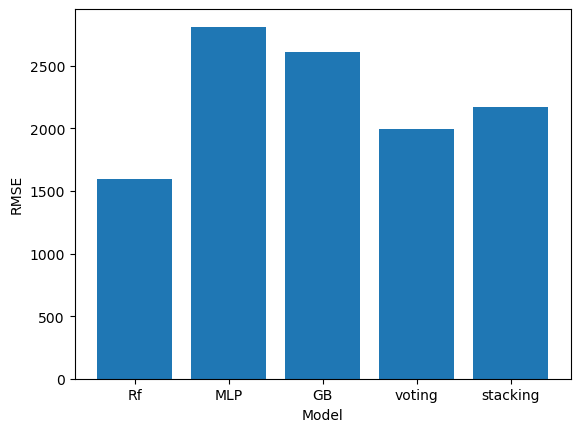

In [399]:
# Plotting the bar graph
plt.bar(results_train_hy['Model'], results_train_hy['RMSE'])

# Labeling x and y axes
plt.xlabel('Model')
plt.ylabel('RMSE')

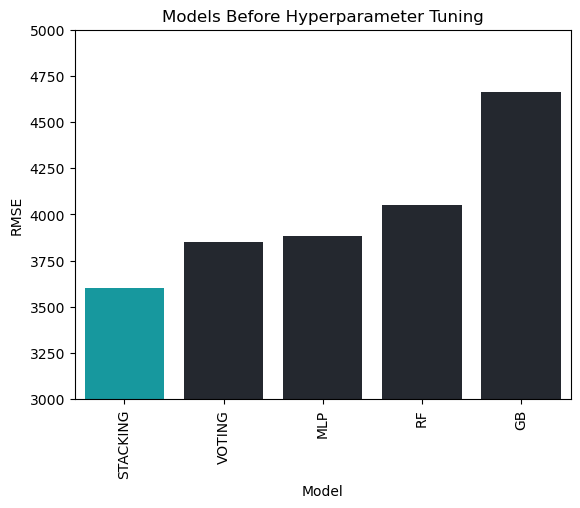

In [400]:
import matplotlib.pyplot as plt
import seaborn as sns


results_test_ = results_test.sort_values(by='RMSE').reset_index(drop=True)

# Plotting the bar graph with Seaborn
ax = sns.barplot(data=results_test_, x='Model', y='RMSE', palette=['#00ADB5' if x == results_test_['RMSE'].min() else '#222831' for x in results_test_['RMSE']])

# Labeling x and y axes
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Models Before Hyperparameter Tuning')
# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=90)
plt.ylim(3000, 5000)
# Show the plot
plt.show()

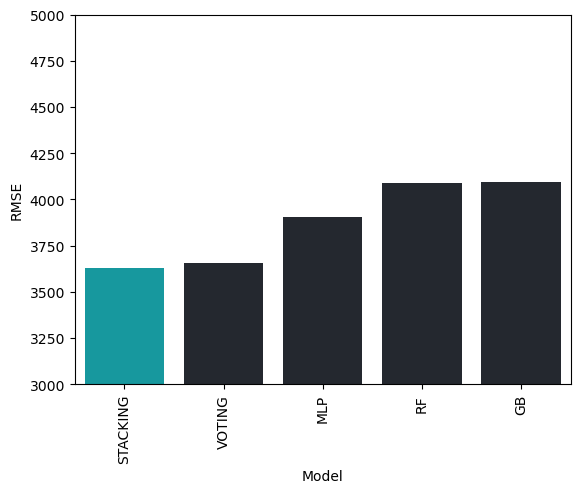

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

results_test_hy_ = results_test_hy.sort_values(by='RMSE').reset_index(drop=True)

ax = sns.barplot(data=results_test_hy_, x='Model', y='RMSE', palette=['#00ADB5' if x == results_test_hy_['RMSE'].min() else '#222831' for x in results_test_hy_['RMSE']])

# Labeling x and y axes
plt.xlabel('Model')
plt.ylabel('RMSE')
# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=90)
plt.ylim(3000, 5000)
# Show the plot
plt.show()


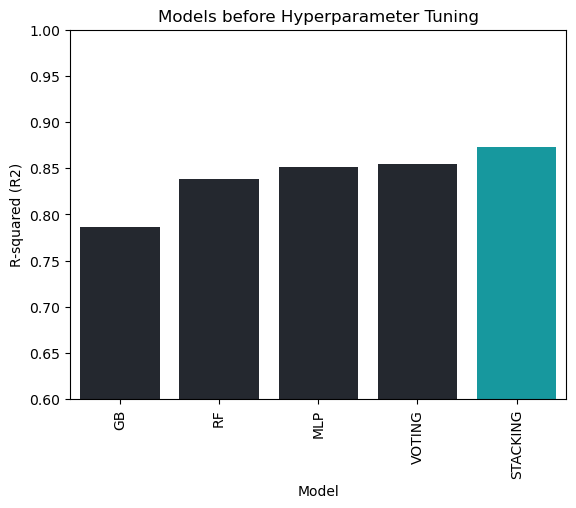

In [402]:
results_test_ = results_test.sort_values(by='R-squared (R2)').reset_index(drop=True)

ax = sns.barplot(data=results_test_, x='Model', y='R-squared (R2)', palette=['#00ADB5' if x == results_test_['R-squared (R2)'].max() else '#222831' for x in results_test_['R-squared (R2)']])

# Labeling x and y axes
plt.xlabel('Model')
plt.ylabel('R-squared (R2)')
plt.title('Models before Hyperparameter Tuning')
# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=90)
plt.ylim(0.6, 1)

# Show the plot
plt.show()

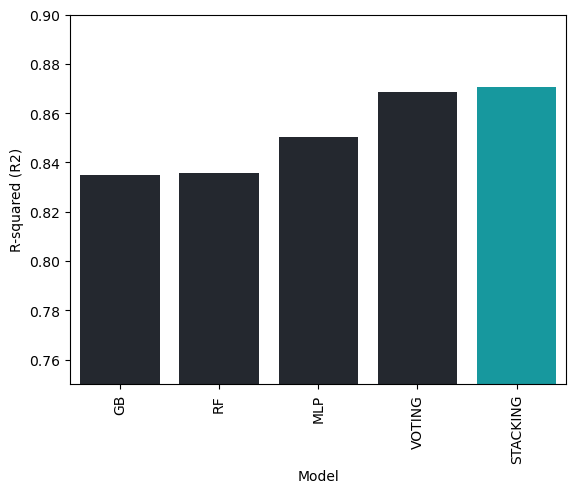

In [403]:
results_test_hy_ = results_test_hy.sort_values(by='R-squared (R2)').reset_index(drop=True)

ax = sns.barplot(data=results_test_hy_, x='Model', y='R-squared (R2)', palette=['#00ADB5' if x == results_test_hy_['R-squared (R2)'].max() else '#222831' for x in results_test_hy_['R-squared (R2)']])

# Labeling x and y axes
plt.xlabel('Model')
plt.ylabel('R-squared (R2)')
# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=90)
plt.ylim(0.75, 0.9)
# Show the plot
plt.show()

#### evaluating models based on types

In [404]:
def evaluate_model_for_types(desc, df, clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    X_test["pred"] = y_pred
    X_test["True"] = y_test
    X_test["Error"] = np.sqrt((X_test["True"] - X_test["pred"]) ** 2)
    
    # Compute RMSE and R-squared for each type
    type_rmse = X_test.groupby(["type"])["Error"].mean()
    
    type_r2 = X_test.groupby(["type"]).apply(lambda x: r2_score(x["True"], x["pred"]))
    
    for t in X_test["type"].unique():
        type_subset = X_test[X_test["type"] == t]
        y_subset = type_subset["True"]
        y_pred_subset = type_subset["pred"]
        rmse = np.sqrt(mean_squared_error(y_subset, y_pred_subset))
        r2 = r2_score(y_subset, y_pred_subset)
        df.loc[len(df.index)] = [t , rmse, r2]
results_types = pd.DataFrame(columns=['Car Type', 'RMSE', 'R-squared (R2)'])

In [405]:
evaluate_model_for_types("STACKING",results_types, hy_stacking_pipeline ,X_test,y_test)
results_types

,Car Type,RMSE,R-squared (R2)
0,supuv,3063.426467,0.889990
1,sedan,3803.622227,0.724137
2,hatchback,3693.666955,0.460558
3,pickups,3878.675135,0.851742
4,coupe,6834.910833,0.761868
5,convertible,4056.825989,0.930856
6,wagon,889.118832,0.934024
7,minivan,2657.640372,0.904921


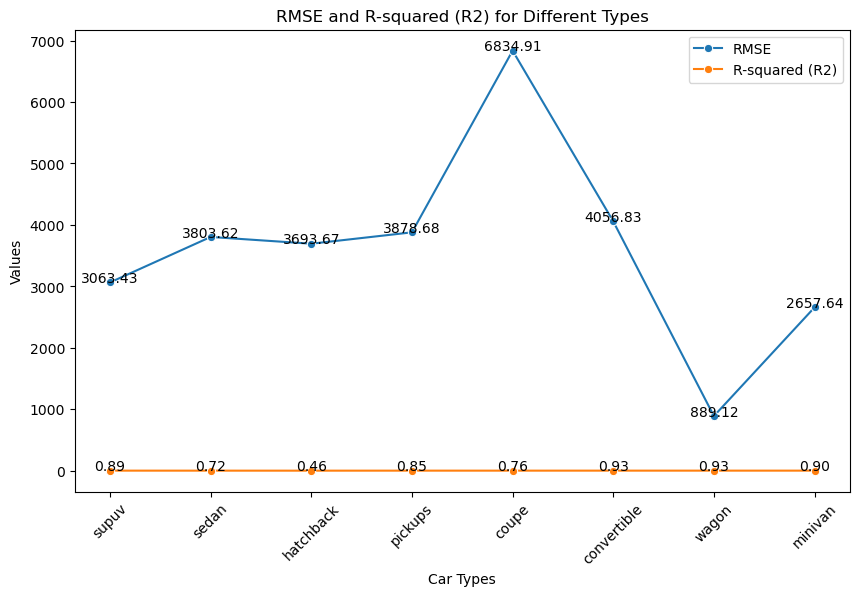

In [406]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=results_types, x='Car Type', y='RMSE', marker='o', label='RMSE')
sns.lineplot(data=results_types, x='Car Type', y='R-squared (R2)', marker='o', label='R-squared (R2)')

# Setting plot title and labels
plt.title('RMSE and R-squared (R2) for Different Types')
plt.xlabel('Car Types')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.legend()

# Annotating specific points
for i in range(len(results_types)):
    plt.text(results_types['Car Type'][i], results_types['RMSE'][i], f"{results_types['RMSE'][i]:.2f}", ha='center')
    plt.text(results_types['Car Type'][i], results_types['R-squared (R2)'][i], f"{results_types['R-squared (R2)'][i]:.2f}", ha='center')

plt.show()


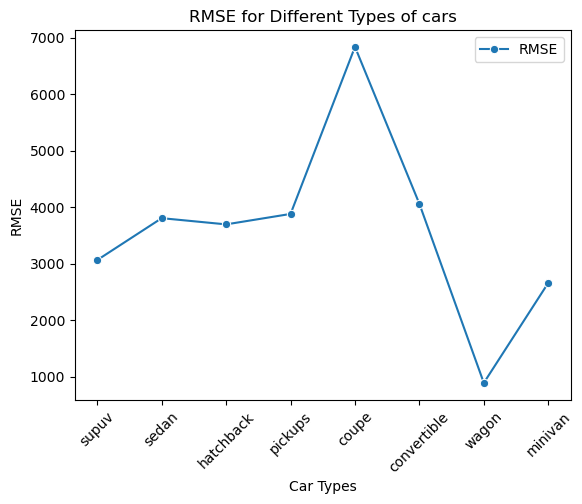

In [408]:
sns.lineplot(data=results_types, x='Car Type', y='RMSE', marker='o', label='RMSE')

# Setting plot title and labels
plt.title('RMSE for Different Types of cars')
plt.xlabel('Car Types')
plt.ylabel('RMSE')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability

plt.legend()

plt.show()

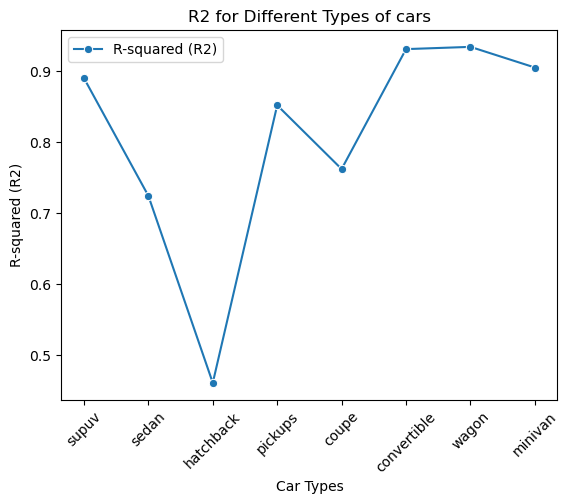

In [409]:
sns.lineplot(data=results_types, x='Car Type', y='R-squared (R2)', marker='o',label='R-squared (R2)')

# Setting plot title and labels
plt.title('R2 for Different Types of cars')
plt.xlabel('Car Types')
plt.ylabel('R-squared (R2)')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability

plt.legend()

plt.show()